#### This notebook will discuss the GANs

In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vishesh1412/celebrity-face-image-dataset")

print("Path to dataset files:", path)

Path to dataset files: /home/blackcat/.cache/kagglehub/datasets/vishesh1412/celebrity-face-image-dataset/versions/1


In [3]:
DATA_DIR = path
image_size = 64
batch_size = 256
states = (0.5,0.5,0.5),(0.5,0.5,0.5)

In [4]:
train_ds =ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*states)
]))


train_dl = DataLoader(train_ds, batch_size, shuffle=True, pin_memory=True)

In [5]:
import torch 
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline 

In [6]:
def denorm(img_tensors):
    return img_tensors * states[1][0] + states[0][0]

In [8]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_xticks([]);ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), 
                        nrow=8).permute(1,2,0))

def show_batch(d1,nmax=64):
    for images, _ in d1:
        show_images(images, nmax)
        break


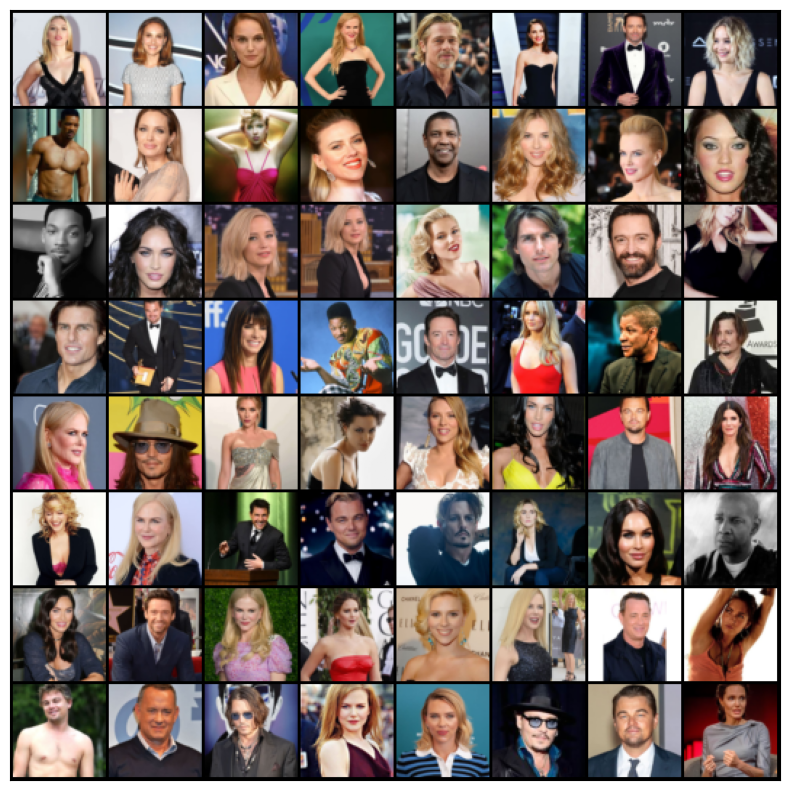

In [9]:
show_batch(train_dl)

In [10]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking = True)

class DeviceDataLoader():
    def __init__(self, d1, device):
        self.d1=d1
        self.device = device
    
    def __iter__(self):
        for b in self.d1:
            yield to_device(b, self.device)

        def __len__(self):
            return len(self.d1)

In [11]:
device = get_default_device()
device

device(type='cpu')

In [12]:
train_dl = DeviceDataLoader(train_dl, device)

In [13]:
import torch.nn as nn

In [14]:
discriminator = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),

    nn.Flatten(),
    nn.Sigmoid()


)

In [15]:
discriminator = to_device(discriminator, device)

In [16]:
latent_size = 128

In [17]:
generator = nn.Sequential(
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()


)

In [18]:
generator = to_device(generator, device)

In [19]:
import torch.nn.functional as F
def train_discriminator(real_images, opt_d):

    opt_d.zero_grad()
    real_preds =discriminator(real_images)
    real_targets = torch.ones(real_images.size(0),1,device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    fake_targets = torch.zeros(fake_images.size(0),1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    loss = real_loss + fake_loss
    loss.backward()
    #opt_d.stop()
    return loss.item(), real_score, fake_score

In [20]:
import torch.nn.functional as F
def train_generator(opt_g):
    opt_g.zero_grad()

    latent = torch.randn(batch_size, latent_size, 1,1, device=device)
    fake_image = generator(latent)

    preds = discriminator(fake_image)
    targets = torch.ones(batch_size,1,device=device)
    loss = F.binary_cross_entropy(preds, targets)

    loss.backward()
    #opt_g.stop()

    return loss.item()

In [21]:
from torchvision.utils import save_image

In [22]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [24]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated_image_{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8,8))
        ax.set_xticks([]);ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1,2,0))

In [25]:
fixed_latent = torch.rand(64, latent_size, 1,1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99976003..0.999912].


Saving generated_image_0000.png


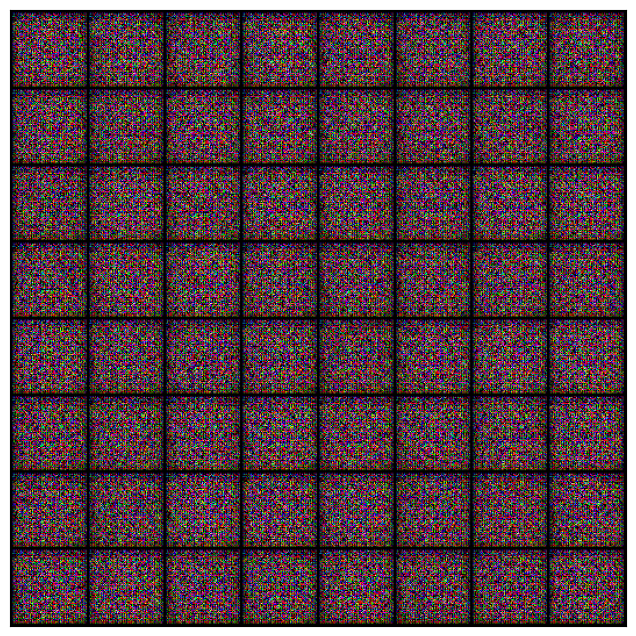

In [26]:
save_samples(0,fixed_latent)

In [27]:
from tqdm import tqdm
import torch.nn.functional as F

In [30]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()


    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))


    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):

            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            loss_g = train_generator(opt_g)

        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)



        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score
        ))

        save_samples(epoch+start_idx, fixed_latent, show=False)
    return losses_g, losses_d, real_scores, fake_scores



In [31]:
!pip3 install IProgress
!pip3 install ipywidgets

In [32]:
%%time
lr = 0.005
epochs = 400 #to get better result need to update this to 500 but will take huge huge time
history = fit(epochs, lr)

8it [00:53,  6.68s/it]


Epoch [1/400], loss_g: 0.6251, loss_d: 1.4231, real_score: 0.5297, fake_score: 0.5368
Saving generated_image_0001.png


8it [00:54,  6.76s/it]


Epoch [2/400], loss_g: 0.6302, loss_d: 1.4559, real_score: 0.5117, fake_score: 0.5333
Saving generated_image_0002.png


8it [00:54,  6.84s/it]


Epoch [3/400], loss_g: 0.6509, loss_d: 1.4446, real_score: 0.5335, fake_score: 0.5380
Saving generated_image_0003.png


8it [00:55,  6.92s/it]


Epoch [4/400], loss_g: 0.6352, loss_d: 1.3249, real_score: 0.5859, fake_score: 0.5359
Saving generated_image_0004.png


8it [00:56,  7.07s/it]


Epoch [5/400], loss_g: 0.6311, loss_d: 1.4262, real_score: 0.5339, fake_score: 0.5400
Saving generated_image_0005.png


8it [00:57,  7.16s/it]


Epoch [6/400], loss_g: 0.6577, loss_d: 1.4897, real_score: 0.5195, fake_score: 0.5436
Saving generated_image_0006.png


8it [00:56,  7.10s/it]


Epoch [7/400], loss_g: 0.6403, loss_d: 1.4328, real_score: 0.5230, fake_score: 0.5330
Saving generated_image_0007.png


8it [00:56,  7.07s/it]


Epoch [8/400], loss_g: 0.6590, loss_d: 1.4501, real_score: 0.5211, fake_score: 0.5361
Saving generated_image_0008.png


8it [00:57,  7.18s/it]


Epoch [9/400], loss_g: 0.6280, loss_d: 1.4641, real_score: 0.5058, fake_score: 0.5336
Saving generated_image_0009.png


8it [00:56,  7.07s/it]


Epoch [10/400], loss_g: 0.6390, loss_d: 1.4000, real_score: 0.5474, fake_score: 0.5374
Saving generated_image_0010.png


8it [00:55,  6.90s/it]


Epoch [11/400], loss_g: 0.6334, loss_d: 1.4737, real_score: 0.5096, fake_score: 0.5353
Saving generated_image_0011.png


8it [00:53,  6.75s/it]


Epoch [12/400], loss_g: 0.6348, loss_d: 1.5063, real_score: 0.5173, fake_score: 0.5461
Saving generated_image_0012.png


8it [00:54,  6.75s/it]


Epoch [13/400], loss_g: 0.6375, loss_d: 1.4189, real_score: 0.5328, fake_score: 0.5355
Saving generated_image_0013.png


8it [00:54,  6.83s/it]


Epoch [14/400], loss_g: 0.6395, loss_d: 1.4828, real_score: 0.5009, fake_score: 0.5379
Saving generated_image_0014.png


8it [00:53,  6.75s/it]


Epoch [15/400], loss_g: 0.6218, loss_d: 1.4242, real_score: 0.5450, fake_score: 0.5434
Saving generated_image_0015.png


8it [00:55,  6.92s/it]


Epoch [16/400], loss_g: 0.6316, loss_d: 1.4541, real_score: 0.5265, fake_score: 0.5398
Saving generated_image_0016.png


8it [00:55,  6.95s/it]


Epoch [17/400], loss_g: 0.6426, loss_d: 1.3879, real_score: 0.5443, fake_score: 0.5313
Saving generated_image_0017.png


8it [00:53,  6.71s/it]


Epoch [18/400], loss_g: 0.6285, loss_d: 1.4330, real_score: 0.5293, fake_score: 0.5379
Saving generated_image_0018.png


8it [00:53,  6.75s/it]


Epoch [19/400], loss_g: 0.6378, loss_d: 1.3443, real_score: 0.5718, fake_score: 0.5336
Saving generated_image_0019.png


8it [00:57,  7.19s/it]


Epoch [20/400], loss_g: 0.6297, loss_d: 1.4610, real_score: 0.5198, fake_score: 0.5430
Saving generated_image_0020.png


8it [00:57,  7.18s/it]


Epoch [21/400], loss_g: 0.6418, loss_d: 1.3135, real_score: 0.5834, fake_score: 0.5287
Saving generated_image_0021.png


8it [00:55,  6.91s/it]


Epoch [22/400], loss_g: 0.6467, loss_d: 1.3734, real_score: 0.5561, fake_score: 0.5339
Saving generated_image_0022.png


8it [00:53,  6.66s/it]


Epoch [23/400], loss_g: 0.6300, loss_d: 1.3802, real_score: 0.5555, fake_score: 0.5373
Saving generated_image_0023.png


8it [00:52,  6.62s/it]


Epoch [24/400], loss_g: 0.6211, loss_d: 1.4952, real_score: 0.4921, fake_score: 0.5346
Saving generated_image_0024.png


8it [00:53,  6.68s/it]


Epoch [25/400], loss_g: 0.6320, loss_d: 1.3984, real_score: 0.5472, fake_score: 0.5355
Saving generated_image_0025.png


8it [00:53,  6.66s/it]


Epoch [26/400], loss_g: 0.6496, loss_d: 1.4146, real_score: 0.5336, fake_score: 0.5356
Saving generated_image_0026.png


8it [00:55,  6.89s/it]


Epoch [27/400], loss_g: 0.6574, loss_d: 1.3567, real_score: 0.5654, fake_score: 0.5329
Saving generated_image_0027.png


8it [00:52,  6.57s/it]


Epoch [28/400], loss_g: 0.6309, loss_d: 1.3553, real_score: 0.5694, fake_score: 0.5367
Saving generated_image_0028.png


8it [00:51,  6.46s/it]


Epoch [29/400], loss_g: 0.6388, loss_d: 1.4199, real_score: 0.5433, fake_score: 0.5312
Saving generated_image_0029.png


8it [00:51,  6.44s/it]


Epoch [30/400], loss_g: 0.6364, loss_d: 1.3484, real_score: 0.5789, fake_score: 0.5407
Saving generated_image_0030.png


8it [00:50,  6.36s/it]


Epoch [31/400], loss_g: 0.6236, loss_d: 1.3936, real_score: 0.5530, fake_score: 0.5411
Saving generated_image_0031.png


8it [00:51,  6.41s/it]


Epoch [32/400], loss_g: 0.6497, loss_d: 1.3714, real_score: 0.5532, fake_score: 0.5314
Saving generated_image_0032.png


8it [00:52,  6.61s/it]


Epoch [33/400], loss_g: 0.6439, loss_d: 1.4263, real_score: 0.5438, fake_score: 0.5460
Saving generated_image_0033.png


8it [00:52,  6.56s/it]


Epoch [34/400], loss_g: 0.6402, loss_d: 1.3266, real_score: 0.5709, fake_score: 0.5262
Saving generated_image_0034.png


8it [00:55,  6.90s/it]


Epoch [35/400], loss_g: 0.6475, loss_d: 1.4525, real_score: 0.5177, fake_score: 0.5373
Saving generated_image_0035.png


8it [00:54,  6.76s/it]


Epoch [36/400], loss_g: 0.6430, loss_d: 1.4809, real_score: 0.5062, fake_score: 0.5397
Saving generated_image_0036.png


8it [00:53,  6.71s/it]


Epoch [37/400], loss_g: 0.6269, loss_d: 1.4522, real_score: 0.5055, fake_score: 0.5271
Saving generated_image_0037.png


8it [00:55,  6.96s/it]


Epoch [38/400], loss_g: 0.6330, loss_d: 1.3465, real_score: 0.5838, fake_score: 0.5370
Saving generated_image_0038.png


8it [00:55,  6.92s/it]


Epoch [39/400], loss_g: 0.6226, loss_d: 1.2989, real_score: 0.6090, fake_score: 0.5425
Saving generated_image_0039.png


8it [00:54,  6.87s/it]


Epoch [40/400], loss_g: 0.6570, loss_d: 1.3781, real_score: 0.5502, fake_score: 0.5316
Saving generated_image_0040.png


8it [00:54,  6.76s/it]


Epoch [41/400], loss_g: 0.6461, loss_d: 1.3353, real_score: 0.5818, fake_score: 0.5335
Saving generated_image_0041.png


8it [00:54,  6.84s/it]


Epoch [42/400], loss_g: 0.6348, loss_d: 1.4644, real_score: 0.5305, fake_score: 0.5396
Saving generated_image_0042.png


8it [00:54,  6.84s/it]


Epoch [43/400], loss_g: 0.6398, loss_d: 1.3387, real_score: 0.5689, fake_score: 0.5286
Saving generated_image_0043.png


8it [00:56,  7.00s/it]


Epoch [44/400], loss_g: 0.6378, loss_d: 1.4274, real_score: 0.5316, fake_score: 0.5376
Saving generated_image_0044.png


8it [00:55,  6.93s/it]


Epoch [45/400], loss_g: 0.6229, loss_d: 1.5482, real_score: 0.4761, fake_score: 0.5348
Saving generated_image_0045.png


8it [00:54,  6.81s/it]


Epoch [46/400], loss_g: 0.6246, loss_d: 1.3980, real_score: 0.5359, fake_score: 0.5282
Saving generated_image_0046.png


8it [00:54,  6.84s/it]


Epoch [47/400], loss_g: 0.6341, loss_d: 1.4817, real_score: 0.4950, fake_score: 0.5301
Saving generated_image_0047.png


8it [00:54,  6.81s/it]


Epoch [48/400], loss_g: 0.6431, loss_d: 1.3596, real_score: 0.5616, fake_score: 0.5322
Saving generated_image_0048.png


8it [00:54,  6.78s/it]


Epoch [49/400], loss_g: 0.6258, loss_d: 1.3779, real_score: 0.5522, fake_score: 0.5324
Saving generated_image_0049.png


8it [00:52,  6.60s/it]


Epoch [50/400], loss_g: 0.6208, loss_d: 1.4284, real_score: 0.5364, fake_score: 0.5429
Saving generated_image_0050.png


8it [00:51,  6.49s/it]


Epoch [51/400], loss_g: 0.6468, loss_d: 1.4377, real_score: 0.5157, fake_score: 0.5301
Saving generated_image_0051.png


8it [00:52,  6.51s/it]


Epoch [52/400], loss_g: 0.6247, loss_d: 1.3997, real_score: 0.5437, fake_score: 0.5362
Saving generated_image_0052.png


8it [00:51,  6.48s/it]


Epoch [53/400], loss_g: 0.6298, loss_d: 1.4090, real_score: 0.5324, fake_score: 0.5316
Saving generated_image_0053.png


8it [00:52,  6.55s/it]


Epoch [54/400], loss_g: 0.6512, loss_d: 1.4475, real_score: 0.5200, fake_score: 0.5346
Saving generated_image_0054.png


8it [00:52,  6.54s/it]


Epoch [55/400], loss_g: 0.6312, loss_d: 1.3911, real_score: 0.5511, fake_score: 0.5392
Saving generated_image_0055.png


8it [00:51,  6.43s/it]


Epoch [56/400], loss_g: 0.6318, loss_d: 1.3889, real_score: 0.5380, fake_score: 0.5293
Saving generated_image_0056.png


8it [00:51,  6.41s/it]


Epoch [57/400], loss_g: 0.6325, loss_d: 1.4264, real_score: 0.5290, fake_score: 0.5358
Saving generated_image_0057.png


8it [00:51,  6.48s/it]


Epoch [58/400], loss_g: 0.6412, loss_d: 1.4578, real_score: 0.5140, fake_score: 0.5352
Saving generated_image_0058.png


8it [00:51,  6.43s/it]


Epoch [59/400], loss_g: 0.6308, loss_d: 1.4735, real_score: 0.5040, fake_score: 0.5314
Saving generated_image_0059.png


8it [00:51,  6.41s/it]


Epoch [60/400], loss_g: 0.6514, loss_d: 1.3849, real_score: 0.5464, fake_score: 0.5289
Saving generated_image_0060.png


8it [00:52,  6.59s/it]


Epoch [61/400], loss_g: 0.6423, loss_d: 1.3694, real_score: 0.5605, fake_score: 0.5354
Saving generated_image_0061.png


8it [00:52,  6.60s/it]


Epoch [62/400], loss_g: 0.6325, loss_d: 1.4894, real_score: 0.5012, fake_score: 0.5349
Saving generated_image_0062.png


8it [00:51,  6.38s/it]


Epoch [63/400], loss_g: 0.6311, loss_d: 1.4796, real_score: 0.5118, fake_score: 0.5450
Saving generated_image_0063.png


8it [00:51,  6.45s/it]


Epoch [64/400], loss_g: 0.6249, loss_d: 1.3585, real_score: 0.5610, fake_score: 0.5291
Saving generated_image_0064.png


8it [00:51,  6.40s/it]


Epoch [65/400], loss_g: 0.6421, loss_d: 1.3778, real_score: 0.5552, fake_score: 0.5362
Saving generated_image_0065.png


8it [00:52,  6.61s/it]


Epoch [66/400], loss_g: 0.6668, loss_d: 1.4465, real_score: 0.5194, fake_score: 0.5350
Saving generated_image_0066.png


8it [00:52,  6.54s/it]


Epoch [67/400], loss_g: 0.6179, loss_d: 1.4274, real_score: 0.5366, fake_score: 0.5407
Saving generated_image_0067.png


8it [00:51,  6.40s/it]


Epoch [68/400], loss_g: 0.6566, loss_d: 1.4785, real_score: 0.5042, fake_score: 0.5307
Saving generated_image_0068.png


8it [00:55,  6.89s/it]


Epoch [69/400], loss_g: 0.6503, loss_d: 1.4490, real_score: 0.5273, fake_score: 0.5421
Saving generated_image_0069.png


8it [00:54,  6.82s/it]


Epoch [70/400], loss_g: 0.6392, loss_d: 1.3917, real_score: 0.5532, fake_score: 0.5400
Saving generated_image_0070.png


8it [00:55,  6.96s/it]


Epoch [71/400], loss_g: 0.6281, loss_d: 1.3210, real_score: 0.5813, fake_score: 0.5292
Saving generated_image_0071.png


8it [00:55,  6.93s/it]


Epoch [72/400], loss_g: 0.6468, loss_d: 1.4070, real_score: 0.5478, fake_score: 0.5317
Saving generated_image_0072.png


8it [00:56,  7.06s/it]


Epoch [73/400], loss_g: 0.6331, loss_d: 1.4447, real_score: 0.5152, fake_score: 0.5299
Saving generated_image_0073.png


8it [00:55,  6.88s/it]


Epoch [74/400], loss_g: 0.6421, loss_d: 1.3922, real_score: 0.5550, fake_score: 0.5404
Saving generated_image_0074.png


8it [00:55,  6.92s/it]


Epoch [75/400], loss_g: 0.6394, loss_d: 1.4419, real_score: 0.5173, fake_score: 0.5296
Saving generated_image_0075.png


8it [00:54,  6.81s/it]


Epoch [76/400], loss_g: 0.6430, loss_d: 1.3566, real_score: 0.5623, fake_score: 0.5327
Saving generated_image_0076.png


8it [00:56,  7.02s/it]


Epoch [77/400], loss_g: 0.6523, loss_d: 1.3280, real_score: 0.5803, fake_score: 0.5321
Saving generated_image_0077.png


8it [00:54,  6.85s/it]


Epoch [78/400], loss_g: 0.6422, loss_d: 1.3831, real_score: 0.5424, fake_score: 0.5280
Saving generated_image_0078.png


8it [00:55,  6.90s/it]


Epoch [79/400], loss_g: 0.6299, loss_d: 1.3774, real_score: 0.5557, fake_score: 0.5350
Saving generated_image_0079.png


8it [00:54,  6.82s/it]


Epoch [80/400], loss_g: 0.6416, loss_d: 1.4136, real_score: 0.5331, fake_score: 0.5329
Saving generated_image_0080.png


8it [00:54,  6.76s/it]


Epoch [81/400], loss_g: 0.6233, loss_d: 1.4264, real_score: 0.5390, fake_score: 0.5409
Saving generated_image_0081.png


8it [00:53,  6.74s/it]


Epoch [82/400], loss_g: 0.6451, loss_d: 1.4735, real_score: 0.5162, fake_score: 0.5376
Saving generated_image_0082.png


8it [00:56,  7.08s/it]


Epoch [83/400], loss_g: 0.6195, loss_d: 1.5168, real_score: 0.4975, fake_score: 0.5436
Saving generated_image_0083.png


8it [00:55,  6.94s/it]


Epoch [84/400], loss_g: 0.6322, loss_d: 1.4794, real_score: 0.5008, fake_score: 0.5329
Saving generated_image_0084.png


8it [00:54,  6.84s/it]


Epoch [85/400], loss_g: 0.6191, loss_d: 1.3688, real_score: 0.5620, fake_score: 0.5340
Saving generated_image_0085.png


8it [00:54,  6.86s/it]


Epoch [86/400], loss_g: 0.6371, loss_d: 1.4617, real_score: 0.5154, fake_score: 0.5380
Saving generated_image_0086.png


8it [00:54,  6.81s/it]


Epoch [87/400], loss_g: 0.6266, loss_d: 1.4243, real_score: 0.5444, fake_score: 0.5424
Saving generated_image_0087.png


8it [00:54,  6.85s/it]


Epoch [88/400], loss_g: 0.6336, loss_d: 1.3839, real_score: 0.5585, fake_score: 0.5389
Saving generated_image_0088.png


8it [00:54,  6.80s/it]


Epoch [89/400], loss_g: 0.6350, loss_d: 1.3274, real_score: 0.5880, fake_score: 0.5382
Saving generated_image_0089.png


8it [00:54,  6.76s/it]


Epoch [90/400], loss_g: 0.6405, loss_d: 1.4150, real_score: 0.5336, fake_score: 0.5336
Saving generated_image_0090.png


8it [00:54,  6.79s/it]


Epoch [91/400], loss_g: 0.6384, loss_d: 1.5151, real_score: 0.4821, fake_score: 0.5316
Saving generated_image_0091.png


8it [00:55,  6.95s/it]


Epoch [92/400], loss_g: 0.6335, loss_d: 1.4884, real_score: 0.5140, fake_score: 0.5415
Saving generated_image_0092.png


8it [00:54,  6.82s/it]


Epoch [93/400], loss_g: 0.6505, loss_d: 1.4690, real_score: 0.5114, fake_score: 0.5396
Saving generated_image_0093.png


8it [00:56,  7.05s/it]


Epoch [94/400], loss_g: 0.6348, loss_d: 1.4773, real_score: 0.5026, fake_score: 0.5343
Saving generated_image_0094.png


8it [00:55,  6.99s/it]


Epoch [95/400], loss_g: 0.6189, loss_d: 1.4638, real_score: 0.5138, fake_score: 0.5392
Saving generated_image_0095.png


8it [00:54,  6.87s/it]


Epoch [96/400], loss_g: 0.6499, loss_d: 1.3660, real_score: 0.5580, fake_score: 0.5344
Saving generated_image_0096.png


8it [00:56,  7.04s/it]


Epoch [97/400], loss_g: 0.6423, loss_d: 1.4673, real_score: 0.5199, fake_score: 0.5343
Saving generated_image_0097.png


8it [00:55,  6.96s/it]


Epoch [98/400], loss_g: 0.6259, loss_d: 1.4196, real_score: 0.5307, fake_score: 0.5323
Saving generated_image_0098.png


8it [00:55,  6.93s/it]


Epoch [99/400], loss_g: 0.6225, loss_d: 1.4515, real_score: 0.5095, fake_score: 0.5262
Saving generated_image_0099.png


8it [00:55,  6.91s/it]


Epoch [100/400], loss_g: 0.6376, loss_d: 1.4326, real_score: 0.5342, fake_score: 0.5374
Saving generated_image_0100.png


8it [00:54,  6.84s/it]


Epoch [101/400], loss_g: 0.6395, loss_d: 1.4876, real_score: 0.4969, fake_score: 0.5325
Saving generated_image_0101.png


8it [00:54,  6.78s/it]


Epoch [102/400], loss_g: 0.6303, loss_d: 1.4467, real_score: 0.5152, fake_score: 0.5332
Saving generated_image_0102.png


8it [00:54,  6.76s/it]


Epoch [103/400], loss_g: 0.6241, loss_d: 1.3992, real_score: 0.5426, fake_score: 0.5349
Saving generated_image_0103.png


8it [00:56,  7.12s/it]


Epoch [104/400], loss_g: 0.6508, loss_d: 1.3618, real_score: 0.5594, fake_score: 0.5343
Saving generated_image_0104.png


8it [00:55,  6.99s/it]


Epoch [105/400], loss_g: 0.6295, loss_d: 1.3166, real_score: 0.5836, fake_score: 0.5301
Saving generated_image_0105.png


8it [00:55,  6.90s/it]


Epoch [106/400], loss_g: 0.6386, loss_d: 1.4644, real_score: 0.5176, fake_score: 0.5385
Saving generated_image_0106.png


8it [00:54,  6.82s/it]


Epoch [107/400], loss_g: 0.6349, loss_d: 1.4389, real_score: 0.5287, fake_score: 0.5387
Saving generated_image_0107.png


8it [00:54,  6.78s/it]


Epoch [108/400], loss_g: 0.6453, loss_d: 1.3831, real_score: 0.5675, fake_score: 0.5409
Saving generated_image_0108.png


8it [00:54,  6.84s/it]


Epoch [109/400], loss_g: 0.6391, loss_d: 1.4230, real_score: 0.5325, fake_score: 0.5355
Saving generated_image_0109.png


8it [00:55,  6.99s/it]


Epoch [110/400], loss_g: 0.6325, loss_d: 1.4705, real_score: 0.5092, fake_score: 0.5364
Saving generated_image_0110.png


8it [00:54,  6.86s/it]


Epoch [111/400], loss_g: 0.6391, loss_d: 1.4069, real_score: 0.5403, fake_score: 0.5277
Saving generated_image_0111.png


8it [00:55,  6.94s/it]


Epoch [112/400], loss_g: 0.6330, loss_d: 1.3958, real_score: 0.5499, fake_score: 0.5371
Saving generated_image_0112.png


8it [00:53,  6.73s/it]


Epoch [113/400], loss_g: 0.6444, loss_d: 1.4467, real_score: 0.5197, fake_score: 0.5334
Saving generated_image_0113.png


8it [00:54,  6.77s/it]


Epoch [114/400], loss_g: 0.6237, loss_d: 1.4710, real_score: 0.5062, fake_score: 0.5339
Saving generated_image_0114.png


8it [00:56,  7.10s/it]


Epoch [115/400], loss_g: 0.6517, loss_d: 1.3705, real_score: 0.5619, fake_score: 0.5373
Saving generated_image_0115.png


8it [00:56,  7.09s/it]


Epoch [116/400], loss_g: 0.6358, loss_d: 1.3942, real_score: 0.5440, fake_score: 0.5334
Saving generated_image_0116.png


8it [00:54,  6.78s/it]


Epoch [117/400], loss_g: 0.6480, loss_d: 1.3753, real_score: 0.5572, fake_score: 0.5370
Saving generated_image_0117.png


8it [00:54,  6.84s/it]


Epoch [118/400], loss_g: 0.6387, loss_d: 1.4402, real_score: 0.5208, fake_score: 0.5346
Saving generated_image_0118.png


8it [00:54,  6.79s/it]


Epoch [119/400], loss_g: 0.6438, loss_d: 1.6274, real_score: 0.4401, fake_score: 0.5363
Saving generated_image_0119.png


8it [00:54,  6.81s/it]


Epoch [120/400], loss_g: 0.6183, loss_d: 1.4751, real_score: 0.5095, fake_score: 0.5337
Saving generated_image_0120.png


8it [00:55,  6.95s/it]


Epoch [121/400], loss_g: 0.6561, loss_d: 1.4544, real_score: 0.5200, fake_score: 0.5388
Saving generated_image_0121.png


8it [00:55,  6.93s/it]


Epoch [122/400], loss_g: 0.6361, loss_d: 1.4478, real_score: 0.5274, fake_score: 0.5414
Saving generated_image_0122.png


8it [00:55,  6.88s/it]


Epoch [123/400], loss_g: 0.6320, loss_d: 1.4146, real_score: 0.5383, fake_score: 0.5358
Saving generated_image_0123.png


8it [00:54,  6.87s/it]


Epoch [124/400], loss_g: 0.6493, loss_d: 1.5226, real_score: 0.4971, fake_score: 0.5381
Saving generated_image_0124.png


8it [00:55,  6.90s/it]


Epoch [125/400], loss_g: 0.6251, loss_d: 1.3674, real_score: 0.5575, fake_score: 0.5313
Saving generated_image_0125.png


8it [00:56,  7.12s/it]


Epoch [126/400], loss_g: 0.6453, loss_d: 1.3913, real_score: 0.5553, fake_score: 0.5391
Saving generated_image_0126.png


8it [00:55,  6.89s/it]


Epoch [127/400], loss_g: 0.6319, loss_d: 1.4378, real_score: 0.5184, fake_score: 0.5302
Saving generated_image_0127.png


8it [00:55,  6.88s/it]


Epoch [128/400], loss_g: 0.6604, loss_d: 1.3281, real_score: 0.5869, fake_score: 0.5389
Saving generated_image_0128.png


8it [00:55,  6.98s/it]


Epoch [129/400], loss_g: 0.6459, loss_d: 1.4271, real_score: 0.5357, fake_score: 0.5339
Saving generated_image_0129.png


8it [00:54,  6.84s/it]


Epoch [130/400], loss_g: 0.6420, loss_d: 1.3869, real_score: 0.5521, fake_score: 0.5346
Saving generated_image_0130.png


8it [00:55,  6.97s/it]


Epoch [131/400], loss_g: 0.6357, loss_d: 1.4318, real_score: 0.5371, fake_score: 0.5366
Saving generated_image_0131.png


8it [00:56,  7.08s/it]


Epoch [132/400], loss_g: 0.6280, loss_d: 1.3635, real_score: 0.5589, fake_score: 0.5330
Saving generated_image_0132.png


8it [00:54,  6.77s/it]


Epoch [133/400], loss_g: 0.6404, loss_d: 1.3586, real_score: 0.5538, fake_score: 0.5274
Saving generated_image_0133.png


8it [00:55,  6.90s/it]


Epoch [134/400], loss_g: 0.6343, loss_d: 1.4953, real_score: 0.4995, fake_score: 0.5411
Saving generated_image_0134.png


8it [00:54,  6.86s/it]


Epoch [135/400], loss_g: 0.6340, loss_d: 1.3721, real_score: 0.5488, fake_score: 0.5291
Saving generated_image_0135.png


8it [00:54,  6.81s/it]


Epoch [136/400], loss_g: 0.6317, loss_d: 1.2766, real_score: 0.6269, fake_score: 0.5431
Saving generated_image_0136.png


8it [00:56,  7.02s/it]


Epoch [137/400], loss_g: 0.6172, loss_d: 1.3760, real_score: 0.5464, fake_score: 0.5253
Saving generated_image_0137.png


8it [00:54,  6.87s/it]


Epoch [138/400], loss_g: 0.6342, loss_d: 1.3299, real_score: 0.5775, fake_score: 0.5317
Saving generated_image_0138.png


8it [00:56,  7.08s/it]


Epoch [139/400], loss_g: 0.6448, loss_d: 1.3678, real_score: 0.5647, fake_score: 0.5416
Saving generated_image_0139.png


8it [00:54,  6.82s/it]


Epoch [140/400], loss_g: 0.6330, loss_d: 1.3745, real_score: 0.5583, fake_score: 0.5370
Saving generated_image_0140.png


8it [00:54,  6.80s/it]


Epoch [141/400], loss_g: 0.6406, loss_d: 1.5170, real_score: 0.5134, fake_score: 0.5432
Saving generated_image_0141.png


8it [00:55,  6.89s/it]


Epoch [142/400], loss_g: 0.6312, loss_d: 1.3871, real_score: 0.5423, fake_score: 0.5284
Saving generated_image_0142.png


8it [00:55,  6.89s/it]


Epoch [143/400], loss_g: 0.6513, loss_d: 1.4655, real_score: 0.5148, fake_score: 0.5405
Saving generated_image_0143.png


8it [00:54,  6.85s/it]


Epoch [144/400], loss_g: 0.6365, loss_d: 1.3551, real_score: 0.5660, fake_score: 0.5339
Saving generated_image_0144.png


8it [00:54,  6.75s/it]


Epoch [145/400], loss_g: 0.6575, loss_d: 1.4242, real_score: 0.5440, fake_score: 0.5456
Saving generated_image_0145.png


8it [00:53,  6.73s/it]


Epoch [146/400], loss_g: 0.6317, loss_d: 1.4541, real_score: 0.5221, fake_score: 0.5416
Saving generated_image_0146.png


8it [00:54,  6.82s/it]


Epoch [147/400], loss_g: 0.6438, loss_d: 1.4606, real_score: 0.5019, fake_score: 0.5237
Saving generated_image_0147.png


8it [00:54,  6.81s/it]


Epoch [148/400], loss_g: 0.6403, loss_d: 1.4793, real_score: 0.5107, fake_score: 0.5388
Saving generated_image_0148.png


8it [00:53,  6.71s/it]


Epoch [149/400], loss_g: 0.6569, loss_d: 1.4243, real_score: 0.5356, fake_score: 0.5329
Saving generated_image_0149.png


8it [00:54,  6.75s/it]


Epoch [150/400], loss_g: 0.6335, loss_d: 1.3851, real_score: 0.5530, fake_score: 0.5367
Saving generated_image_0150.png


8it [00:51,  6.43s/it]


Epoch [151/400], loss_g: 0.6390, loss_d: 1.3629, real_score: 0.5543, fake_score: 0.5289
Saving generated_image_0151.png


8it [00:51,  6.41s/it]


Epoch [152/400], loss_g: 0.6374, loss_d: 1.3391, real_score: 0.5771, fake_score: 0.5356
Saving generated_image_0152.png


8it [00:55,  6.94s/it]


Epoch [153/400], loss_g: 0.6326, loss_d: 1.3812, real_score: 0.5546, fake_score: 0.5355
Saving generated_image_0153.png


8it [00:54,  6.87s/it]


Epoch [154/400], loss_g: 0.6416, loss_d: 1.4707, real_score: 0.4970, fake_score: 0.5275
Saving generated_image_0154.png


8it [00:54,  6.77s/it]


Epoch [155/400], loss_g: 0.6334, loss_d: 1.3382, real_score: 0.5783, fake_score: 0.5356
Saving generated_image_0155.png


8it [00:53,  6.72s/it]


Epoch [156/400], loss_g: 0.6208, loss_d: 1.4576, real_score: 0.5150, fake_score: 0.5344
Saving generated_image_0156.png


8it [00:53,  6.70s/it]


Epoch [157/400], loss_g: 0.6467, loss_d: 1.3081, real_score: 0.5825, fake_score: 0.5263
Saving generated_image_0157.png


8it [00:54,  6.76s/it]


Epoch [158/400], loss_g: 0.6357, loss_d: 1.4089, real_score: 0.5384, fake_score: 0.5332
Saving generated_image_0158.png


8it [00:55,  6.93s/it]


Epoch [159/400], loss_g: 0.6317, loss_d: 1.4596, real_score: 0.5189, fake_score: 0.5366
Saving generated_image_0159.png


8it [00:55,  6.93s/it]


Epoch [160/400], loss_g: 0.6292, loss_d: 1.4035, real_score: 0.5377, fake_score: 0.5298
Saving generated_image_0160.png


8it [00:54,  6.77s/it]


Epoch [161/400], loss_g: 0.6405, loss_d: 1.3882, real_score: 0.5484, fake_score: 0.5352
Saving generated_image_0161.png


8it [00:53,  6.72s/it]


Epoch [162/400], loss_g: 0.6390, loss_d: 1.3761, real_score: 0.5471, fake_score: 0.5308
Saving generated_image_0162.png


8it [00:53,  6.67s/it]


Epoch [163/400], loss_g: 0.6265, loss_d: 1.3879, real_score: 0.5465, fake_score: 0.5330
Saving generated_image_0163.png


8it [00:54,  6.85s/it]


Epoch [164/400], loss_g: 0.6434, loss_d: 1.4588, real_score: 0.5160, fake_score: 0.5402
Saving generated_image_0164.png


8it [00:54,  6.87s/it]


Epoch [165/400], loss_g: 0.6585, loss_d: 1.4435, real_score: 0.5266, fake_score: 0.5412
Saving generated_image_0165.png


8it [00:54,  6.82s/it]


Epoch [166/400], loss_g: 0.6360, loss_d: 1.3852, real_score: 0.5473, fake_score: 0.5335
Saving generated_image_0166.png


8it [00:53,  6.74s/it]


Epoch [167/400], loss_g: 0.6303, loss_d: 1.3333, real_score: 0.5763, fake_score: 0.5315
Saving generated_image_0167.png


8it [00:53,  6.75s/it]


Epoch [168/400], loss_g: 0.6264, loss_d: 1.4544, real_score: 0.5147, fake_score: 0.5340
Saving generated_image_0168.png


8it [00:54,  6.76s/it]


Epoch [169/400], loss_g: 0.6362, loss_d: 1.4261, real_score: 0.5329, fake_score: 0.5396
Saving generated_image_0169.png


8it [00:56,  7.01s/it]


Epoch [170/400], loss_g: 0.6342, loss_d: 1.3897, real_score: 0.5585, fake_score: 0.5328
Saving generated_image_0170.png


8it [00:54,  6.87s/it]


Epoch [171/400], loss_g: 0.6364, loss_d: 1.3366, real_score: 0.5724, fake_score: 0.5306
Saving generated_image_0171.png


8it [00:54,  6.84s/it]


Epoch [172/400], loss_g: 0.6512, loss_d: 1.4304, real_score: 0.5307, fake_score: 0.5386
Saving generated_image_0172.png


8it [00:53,  6.67s/it]


Epoch [173/400], loss_g: 0.6431, loss_d: 1.3932, real_score: 0.5479, fake_score: 0.5312
Saving generated_image_0173.png


8it [00:53,  6.71s/it]


Epoch [174/400], loss_g: 0.6364, loss_d: 1.3906, real_score: 0.5486, fake_score: 0.5374
Saving generated_image_0174.png


8it [00:55,  6.91s/it]


Epoch [175/400], loss_g: 0.6389, loss_d: 1.3898, real_score: 0.5454, fake_score: 0.5310
Saving generated_image_0175.png


8it [00:55,  6.99s/it]


Epoch [176/400], loss_g: 0.6407, loss_d: 1.4576, real_score: 0.5130, fake_score: 0.5349
Saving generated_image_0176.png


8it [00:54,  6.87s/it]


Epoch [177/400], loss_g: 0.6376, loss_d: 1.4175, real_score: 0.5501, fake_score: 0.5413
Saving generated_image_0177.png


8it [00:54,  6.82s/it]


Epoch [178/400], loss_g: 0.6391, loss_d: 1.4556, real_score: 0.5324, fake_score: 0.5405
Saving generated_image_0178.png


8it [00:53,  6.74s/it]


Epoch [179/400], loss_g: 0.6457, loss_d: 1.4093, real_score: 0.5378, fake_score: 0.5366
Saving generated_image_0179.png


8it [00:54,  6.80s/it]


Epoch [180/400], loss_g: 0.6433, loss_d: 1.4416, real_score: 0.5202, fake_score: 0.5351
Saving generated_image_0180.png


8it [00:56,  7.06s/it]


Epoch [181/400], loss_g: 0.6290, loss_d: 1.4657, real_score: 0.5071, fake_score: 0.5293
Saving generated_image_0181.png


8it [00:54,  6.86s/it]


Epoch [182/400], loss_g: 0.6346, loss_d: 1.4859, real_score: 0.5036, fake_score: 0.5395
Saving generated_image_0182.png


8it [00:54,  6.79s/it]


Epoch [183/400], loss_g: 0.6394, loss_d: 1.3362, real_score: 0.5829, fake_score: 0.5398
Saving generated_image_0183.png


8it [00:53,  6.66s/it]


Epoch [184/400], loss_g: 0.6309, loss_d: 1.4773, real_score: 0.5158, fake_score: 0.5442
Saving generated_image_0184.png


8it [00:53,  6.68s/it]


Epoch [185/400], loss_g: 0.6314, loss_d: 1.3746, real_score: 0.5503, fake_score: 0.5328
Saving generated_image_0185.png


8it [00:55,  6.95s/it]


Epoch [186/400], loss_g: 0.6369, loss_d: 1.4416, real_score: 0.5211, fake_score: 0.5299
Saving generated_image_0186.png


8it [00:54,  6.86s/it]


Epoch [187/400], loss_g: 0.6341, loss_d: 1.4086, real_score: 0.5353, fake_score: 0.5323
Saving generated_image_0187.png


8it [00:51,  6.43s/it]


Epoch [188/400], loss_g: 0.6468, loss_d: 1.4132, real_score: 0.5372, fake_score: 0.5373
Saving generated_image_0188.png


8it [00:51,  6.41s/it]


Epoch [189/400], loss_g: 0.6481, loss_d: 1.3837, real_score: 0.5552, fake_score: 0.5391
Saving generated_image_0189.png


8it [00:51,  6.39s/it]


Epoch [190/400], loss_g: 0.6464, loss_d: 1.4025, real_score: 0.5448, fake_score: 0.5347
Saving generated_image_0190.png


8it [00:51,  6.43s/it]


Epoch [191/400], loss_g: 0.6411, loss_d: 1.4949, real_score: 0.4995, fake_score: 0.5344
Saving generated_image_0191.png


8it [00:52,  6.56s/it]


Epoch [192/400], loss_g: 0.6307, loss_d: 1.3941, real_score: 0.5479, fake_score: 0.5372
Saving generated_image_0192.png


8it [00:52,  6.52s/it]


Epoch [193/400], loss_g: 0.6322, loss_d: 1.3723, real_score: 0.5584, fake_score: 0.5359
Saving generated_image_0193.png


8it [00:55,  6.93s/it]


Epoch [194/400], loss_g: 0.6232, loss_d: 1.4578, real_score: 0.5160, fake_score: 0.5296
Saving generated_image_0194.png


8it [00:54,  6.81s/it]


Epoch [195/400], loss_g: 0.6528, loss_d: 1.4312, real_score: 0.5384, fake_score: 0.5412
Saving generated_image_0195.png


8it [00:54,  6.83s/it]


Epoch [196/400], loss_g: 0.6236, loss_d: 1.4683, real_score: 0.5112, fake_score: 0.5388
Saving generated_image_0196.png


8it [00:54,  6.77s/it]


Epoch [197/400], loss_g: 0.6390, loss_d: 1.4083, real_score: 0.5422, fake_score: 0.5389
Saving generated_image_0197.png


8it [00:55,  6.88s/it]


Epoch [198/400], loss_g: 0.6489, loss_d: 1.4281, real_score: 0.5321, fake_score: 0.5380
Saving generated_image_0198.png


8it [00:54,  6.82s/it]


Epoch [199/400], loss_g: 0.6292, loss_d: 1.3610, real_score: 0.5734, fake_score: 0.5406
Saving generated_image_0199.png


8it [00:54,  6.83s/it]


Epoch [200/400], loss_g: 0.6393, loss_d: 1.4050, real_score: 0.5394, fake_score: 0.5350
Saving generated_image_0200.png


8it [00:54,  6.80s/it]


Epoch [201/400], loss_g: 0.6531, loss_d: 1.4619, real_score: 0.5212, fake_score: 0.5377
Saving generated_image_0201.png


8it [00:55,  6.97s/it]


Epoch [202/400], loss_g: 0.6466, loss_d: 1.4696, real_score: 0.5093, fake_score: 0.5388
Saving generated_image_0202.png


8it [00:56,  7.08s/it]


Epoch [203/400], loss_g: 0.6509, loss_d: 1.4001, real_score: 0.5343, fake_score: 0.5236
Saving generated_image_0203.png


8it [00:55,  6.95s/it]


Epoch [204/400], loss_g: 0.6286, loss_d: 1.3907, real_score: 0.5571, fake_score: 0.5416
Saving generated_image_0204.png


8it [00:53,  6.74s/it]


Epoch [205/400], loss_g: 0.6255, loss_d: 1.4731, real_score: 0.5008, fake_score: 0.5334
Saving generated_image_0205.png


8it [00:54,  6.77s/it]


Epoch [206/400], loss_g: 0.6328, loss_d: 1.3543, real_score: 0.5689, fake_score: 0.5359
Saving generated_image_0206.png


8it [00:53,  6.73s/it]


Epoch [207/400], loss_g: 0.6273, loss_d: 1.4378, real_score: 0.5156, fake_score: 0.5291
Saving generated_image_0207.png


8it [00:54,  6.84s/it]


Epoch [208/400], loss_g: 0.6354, loss_d: 1.3476, real_score: 0.5655, fake_score: 0.5289
Saving generated_image_0208.png


8it [00:54,  6.83s/it]


Epoch [209/400], loss_g: 0.6349, loss_d: 1.3220, real_score: 0.5896, fake_score: 0.5353
Saving generated_image_0209.png


8it [00:53,  6.75s/it]


Epoch [210/400], loss_g: 0.6414, loss_d: 1.3959, real_score: 0.5462, fake_score: 0.5322
Saving generated_image_0210.png


8it [00:54,  6.77s/it]


Epoch [211/400], loss_g: 0.6393, loss_d: 1.4262, real_score: 0.5362, fake_score: 0.5313
Saving generated_image_0211.png


8it [00:54,  6.77s/it]


Epoch [212/400], loss_g: 0.6499, loss_d: 1.3478, real_score: 0.5626, fake_score: 0.5267
Saving generated_image_0212.png


8it [00:53,  6.75s/it]


Epoch [213/400], loss_g: 0.6386, loss_d: 1.3891, real_score: 0.5432, fake_score: 0.5301
Saving generated_image_0213.png


8it [00:55,  6.96s/it]


Epoch [214/400], loss_g: 0.6245, loss_d: 1.3367, real_score: 0.5744, fake_score: 0.5327
Saving generated_image_0214.png


8it [00:55,  6.98s/it]


Epoch [215/400], loss_g: 0.6382, loss_d: 1.4006, real_score: 0.5424, fake_score: 0.5313
Saving generated_image_0215.png


8it [00:54,  6.76s/it]


Epoch [216/400], loss_g: 0.6533, loss_d: 1.4184, real_score: 0.5432, fake_score: 0.5404
Saving generated_image_0216.png


8it [00:53,  6.67s/it]


Epoch [217/400], loss_g: 0.6396, loss_d: 1.3681, real_score: 0.5626, fake_score: 0.5363
Saving generated_image_0217.png


8it [00:55,  6.89s/it]


Epoch [218/400], loss_g: 0.6617, loss_d: 1.5049, real_score: 0.4958, fake_score: 0.5427
Saving generated_image_0218.png


8it [00:56,  7.03s/it]


Epoch [219/400], loss_g: 0.6327, loss_d: 1.4582, real_score: 0.5160, fake_score: 0.5394
Saving generated_image_0219.png


8it [00:55,  6.96s/it]


Epoch [220/400], loss_g: 0.6352, loss_d: 1.4920, real_score: 0.4828, fake_score: 0.5251
Saving generated_image_0220.png


8it [00:54,  6.79s/it]


Epoch [221/400], loss_g: 0.6328, loss_d: 1.4182, real_score: 0.5343, fake_score: 0.5339
Saving generated_image_0221.png


8it [00:53,  6.67s/it]


Epoch [222/400], loss_g: 0.6463, loss_d: 1.4181, real_score: 0.5535, fake_score: 0.5418
Saving generated_image_0222.png


8it [00:54,  6.80s/it]


Epoch [223/400], loss_g: 0.6257, loss_d: 1.4195, real_score: 0.5220, fake_score: 0.5238
Saving generated_image_0223.png


8it [00:54,  6.83s/it]


Epoch [224/400], loss_g: 0.6413, loss_d: 1.4374, real_score: 0.5208, fake_score: 0.5298
Saving generated_image_0224.png


8it [00:55,  6.99s/it]


Epoch [225/400], loss_g: 0.6419, loss_d: 1.4736, real_score: 0.4989, fake_score: 0.5287
Saving generated_image_0225.png


8it [00:54,  6.84s/it]


Epoch [226/400], loss_g: 0.6555, loss_d: 1.3903, real_score: 0.5409, fake_score: 0.5305
Saving generated_image_0226.png


8it [00:53,  6.67s/it]


Epoch [227/400], loss_g: 0.6317, loss_d: 1.3140, real_score: 0.5834, fake_score: 0.5312
Saving generated_image_0227.png


8it [00:54,  6.79s/it]


Epoch [228/400], loss_g: 0.6283, loss_d: 1.4149, real_score: 0.5352, fake_score: 0.5342
Saving generated_image_0228.png


8it [00:53,  6.71s/it]


Epoch [229/400], loss_g: 0.6348, loss_d: 1.4661, real_score: 0.5164, fake_score: 0.5388
Saving generated_image_0229.png


8it [00:54,  6.85s/it]


Epoch [230/400], loss_g: 0.6405, loss_d: 1.4423, real_score: 0.5348, fake_score: 0.5447
Saving generated_image_0230.png


8it [00:55,  6.88s/it]


Epoch [231/400], loss_g: 0.6312, loss_d: 1.4301, real_score: 0.5290, fake_score: 0.5366
Saving generated_image_0231.png


8it [00:54,  6.82s/it]


Epoch [232/400], loss_g: 0.6424, loss_d: 1.4383, real_score: 0.5339, fake_score: 0.5446
Saving generated_image_0232.png


8it [00:53,  6.75s/it]


Epoch [233/400], loss_g: 0.6296, loss_d: 1.3327, real_score: 0.5814, fake_score: 0.5356
Saving generated_image_0233.png


8it [00:54,  6.78s/it]


Epoch [234/400], loss_g: 0.6382, loss_d: 1.4125, real_score: 0.5351, fake_score: 0.5354
Saving generated_image_0234.png


8it [00:54,  6.77s/it]


Epoch [235/400], loss_g: 0.6580, loss_d: 1.4023, real_score: 0.5519, fake_score: 0.5361
Saving generated_image_0235.png


8it [00:55,  6.88s/it]


Epoch [236/400], loss_g: 0.6290, loss_d: 1.4477, real_score: 0.5109, fake_score: 0.5282
Saving generated_image_0236.png


8it [00:55,  6.91s/it]


Epoch [237/400], loss_g: 0.6323, loss_d: 1.3568, real_score: 0.5699, fake_score: 0.5368
Saving generated_image_0237.png


8it [00:54,  6.86s/it]


Epoch [238/400], loss_g: 0.6537, loss_d: 1.4309, real_score: 0.5321, fake_score: 0.5357
Saving generated_image_0238.png


8it [00:53,  6.74s/it]


Epoch [239/400], loss_g: 0.6347, loss_d: 1.4670, real_score: 0.5266, fake_score: 0.5384
Saving generated_image_0239.png


8it [00:54,  6.82s/it]


Epoch [240/400], loss_g: 0.6310, loss_d: 1.4204, real_score: 0.5249, fake_score: 0.5307
Saving generated_image_0240.png


8it [00:57,  7.16s/it]


Epoch [241/400], loss_g: 0.6470, loss_d: 1.3940, real_score: 0.5428, fake_score: 0.5302
Saving generated_image_0241.png


8it [00:55,  6.88s/it]


Epoch [242/400], loss_g: 0.6506, loss_d: 1.3717, real_score: 0.5581, fake_score: 0.5347
Saving generated_image_0242.png


8it [00:54,  6.76s/it]


Epoch [243/400], loss_g: 0.6455, loss_d: 1.3324, real_score: 0.5879, fake_score: 0.5403
Saving generated_image_0243.png


8it [00:53,  6.75s/it]


Epoch [244/400], loss_g: 0.6478, loss_d: 1.3961, real_score: 0.5473, fake_score: 0.5354
Saving generated_image_0244.png


8it [00:54,  6.81s/it]


Epoch [245/400], loss_g: 0.6442, loss_d: 1.4348, real_score: 0.5305, fake_score: 0.5394
Saving generated_image_0245.png


8it [00:53,  6.73s/it]


Epoch [246/400], loss_g: 0.6516, loss_d: 1.3595, real_score: 0.5653, fake_score: 0.5355
Saving generated_image_0246.png


8it [00:55,  6.98s/it]


Epoch [247/400], loss_g: 0.6261, loss_d: 1.4804, real_score: 0.5069, fake_score: 0.5321
Saving generated_image_0247.png


8it [00:55,  6.88s/it]


Epoch [248/400], loss_g: 0.6494, loss_d: 1.3987, real_score: 0.5380, fake_score: 0.5307
Saving generated_image_0248.png


8it [00:54,  6.82s/it]


Epoch [249/400], loss_g: 0.6380, loss_d: 1.4611, real_score: 0.5070, fake_score: 0.5328
Saving generated_image_0249.png


8it [00:53,  6.74s/it]


Epoch [250/400], loss_g: 0.6372, loss_d: 1.4103, real_score: 0.5312, fake_score: 0.5319
Saving generated_image_0250.png


8it [00:54,  6.81s/it]


Epoch [251/400], loss_g: 0.6472, loss_d: 1.3875, real_score: 0.5534, fake_score: 0.5382
Saving generated_image_0251.png


8it [00:54,  6.87s/it]


Epoch [252/400], loss_g: 0.6357, loss_d: 1.3545, real_score: 0.5614, fake_score: 0.5310
Saving generated_image_0252.png


8it [00:54,  6.86s/it]


Epoch [253/400], loss_g: 0.6234, loss_d: 1.4049, real_score: 0.5358, fake_score: 0.5337
Saving generated_image_0253.png


8it [00:54,  6.83s/it]


Epoch [254/400], loss_g: 0.6273, loss_d: 1.4216, real_score: 0.5418, fake_score: 0.5399
Saving generated_image_0254.png


8it [00:54,  6.80s/it]


Epoch [255/400], loss_g: 0.6512, loss_d: 1.3053, real_score: 0.5959, fake_score: 0.5363
Saving generated_image_0255.png


8it [00:54,  6.77s/it]


Epoch [256/400], loss_g: 0.6477, loss_d: 1.3077, real_score: 0.5839, fake_score: 0.5288
Saving generated_image_0256.png


8it [00:54,  6.84s/it]


Epoch [257/400], loss_g: 0.6286, loss_d: 1.4689, real_score: 0.5161, fake_score: 0.5379
Saving generated_image_0257.png


8it [00:54,  6.85s/it]


Epoch [258/400], loss_g: 0.6418, loss_d: 1.3971, real_score: 0.5295, fake_score: 0.5244
Saving generated_image_0258.png


8it [00:54,  6.84s/it]


Epoch [259/400], loss_g: 0.6551, loss_d: 1.3744, real_score: 0.5618, fake_score: 0.5403
Saving generated_image_0259.png


8it [00:54,  6.85s/it]


Epoch [260/400], loss_g: 0.6425, loss_d: 1.4784, real_score: 0.4981, fake_score: 0.5273
Saving generated_image_0260.png


8it [00:56,  7.12s/it]


Epoch [261/400], loss_g: 0.6388, loss_d: 1.4198, real_score: 0.5389, fake_score: 0.5370
Saving generated_image_0261.png


8it [00:54,  6.84s/it]


Epoch [262/400], loss_g: 0.6410, loss_d: 1.5030, real_score: 0.4916, fake_score: 0.5328
Saving generated_image_0262.png


8it [00:55,  6.96s/it]


Epoch [263/400], loss_g: 0.6356, loss_d: 1.3786, real_score: 0.5666, fake_score: 0.5418
Saving generated_image_0263.png


8it [00:55,  6.94s/it]


Epoch [264/400], loss_g: 0.6348, loss_d: 1.4584, real_score: 0.5203, fake_score: 0.5317
Saving generated_image_0264.png


8it [00:54,  6.85s/it]


Epoch [265/400], loss_g: 0.6357, loss_d: 1.4701, real_score: 0.5066, fake_score: 0.5363
Saving generated_image_0265.png


8it [00:53,  6.70s/it]


Epoch [266/400], loss_g: 0.6357, loss_d: 1.4324, real_score: 0.5349, fake_score: 0.5427
Saving generated_image_0266.png


8it [00:54,  6.84s/it]


Epoch [267/400], loss_g: 0.6593, loss_d: 1.4231, real_score: 0.5426, fake_score: 0.5346
Saving generated_image_0267.png


8it [00:55,  6.94s/it]


Epoch [268/400], loss_g: 0.6356, loss_d: 1.5113, real_score: 0.4896, fake_score: 0.5374
Saving generated_image_0268.png


8it [00:55,  6.95s/it]


Epoch [269/400], loss_g: 0.6388, loss_d: 1.4511, real_score: 0.5182, fake_score: 0.5387
Saving generated_image_0269.png


8it [00:54,  6.79s/it]


Epoch [270/400], loss_g: 0.6480, loss_d: 1.4444, real_score: 0.5388, fake_score: 0.5480
Saving generated_image_0270.png


8it [00:54,  6.79s/it]


Epoch [271/400], loss_g: 0.6420, loss_d: 1.4484, real_score: 0.5101, fake_score: 0.5292
Saving generated_image_0271.png


8it [00:53,  6.67s/it]


Epoch [272/400], loss_g: 0.6338, loss_d: 1.4500, real_score: 0.5167, fake_score: 0.5311
Saving generated_image_0272.png


8it [00:51,  6.49s/it]


Epoch [273/400], loss_g: 0.6368, loss_d: 1.3356, real_score: 0.5763, fake_score: 0.5301
Saving generated_image_0273.png


8it [00:53,  6.67s/it]


Epoch [274/400], loss_g: 0.6349, loss_d: 1.4217, real_score: 0.5311, fake_score: 0.5346
Saving generated_image_0274.png


8it [00:56,  7.00s/it]


Epoch [275/400], loss_g: 0.6442, loss_d: 1.4202, real_score: 0.5362, fake_score: 0.5387
Saving generated_image_0275.png


8it [00:54,  6.83s/it]


Epoch [276/400], loss_g: 0.6256, loss_d: 1.3971, real_score: 0.5375, fake_score: 0.5279
Saving generated_image_0276.png


8it [00:55,  6.91s/it]


Epoch [277/400], loss_g: 0.6393, loss_d: 1.4335, real_score: 0.5180, fake_score: 0.5242
Saving generated_image_0277.png


8it [00:54,  6.85s/it]


Epoch [278/400], loss_g: 0.6429, loss_d: 1.3347, real_score: 0.5881, fake_score: 0.5392
Saving generated_image_0278.png


8it [00:56,  7.06s/it]


Epoch [279/400], loss_g: 0.6198, loss_d: 1.5213, real_score: 0.4867, fake_score: 0.5378
Saving generated_image_0279.png


8it [00:56,  7.03s/it]


Epoch [280/400], loss_g: 0.6401, loss_d: 1.4648, real_score: 0.5235, fake_score: 0.5475
Saving generated_image_0280.png


8it [00:54,  6.87s/it]


Epoch [281/400], loss_g: 0.6367, loss_d: 1.4965, real_score: 0.5041, fake_score: 0.5386
Saving generated_image_0281.png


8it [00:54,  6.80s/it]


Epoch [282/400], loss_g: 0.6512, loss_d: 1.3874, real_score: 0.5635, fake_score: 0.5431
Saving generated_image_0282.png


8it [00:54,  6.85s/it]


Epoch [283/400], loss_g: 0.6311, loss_d: 1.4750, real_score: 0.5162, fake_score: 0.5452
Saving generated_image_0283.png


8it [00:54,  6.85s/it]


Epoch [284/400], loss_g: 0.6268, loss_d: 1.3770, real_score: 0.5604, fake_score: 0.5379
Saving generated_image_0284.png


8it [00:55,  6.97s/it]


Epoch [285/400], loss_g: 0.6363, loss_d: 1.4619, real_score: 0.5118, fake_score: 0.5377
Saving generated_image_0285.png


8it [00:55,  6.89s/it]


Epoch [286/400], loss_g: 0.6435, loss_d: 1.3269, real_score: 0.5728, fake_score: 0.5272
Saving generated_image_0286.png


8it [00:54,  6.84s/it]


Epoch [287/400], loss_g: 0.6205, loss_d: 1.4086, real_score: 0.5399, fake_score: 0.5362
Saving generated_image_0287.png


8it [00:53,  6.73s/it]


Epoch [288/400], loss_g: 0.6456, loss_d: 1.4266, real_score: 0.5369, fake_score: 0.5383
Saving generated_image_0288.png


8it [00:55,  6.88s/it]


Epoch [289/400], loss_g: 0.6337, loss_d: 1.3988, real_score: 0.5352, fake_score: 0.5278
Saving generated_image_0289.png


8it [00:55,  6.91s/it]


Epoch [290/400], loss_g: 0.6485, loss_d: 1.4455, real_score: 0.5257, fake_score: 0.5413
Saving generated_image_0290.png


8it [00:55,  6.94s/it]


Epoch [291/400], loss_g: 0.6307, loss_d: 1.3445, real_score: 0.5717, fake_score: 0.5329
Saving generated_image_0291.png


8it [00:54,  6.87s/it]


Epoch [292/400], loss_g: 0.6273, loss_d: 1.4098, real_score: 0.5395, fake_score: 0.5315
Saving generated_image_0292.png


8it [00:54,  6.81s/it]


Epoch [293/400], loss_g: 0.6314, loss_d: 1.4415, real_score: 0.5303, fake_score: 0.5301
Saving generated_image_0293.png


8it [00:54,  6.83s/it]


Epoch [294/400], loss_g: 0.6476, loss_d: 1.4280, real_score: 0.5383, fake_score: 0.5427
Saving generated_image_0294.png


8it [00:54,  6.78s/it]


Epoch [295/400], loss_g: 0.6290, loss_d: 1.3976, real_score: 0.5380, fake_score: 0.5257
Saving generated_image_0295.png


8it [00:55,  6.95s/it]


Epoch [296/400], loss_g: 0.6397, loss_d: 1.4446, real_score: 0.5359, fake_score: 0.5424
Saving generated_image_0296.png


8it [00:56,  7.04s/it]


Epoch [297/400], loss_g: 0.6269, loss_d: 1.4261, real_score: 0.5315, fake_score: 0.5349
Saving generated_image_0297.png


8it [00:54,  6.82s/it]


Epoch [298/400], loss_g: 0.6476, loss_d: 1.4787, real_score: 0.5135, fake_score: 0.5355
Saving generated_image_0298.png


8it [00:54,  6.79s/it]


Epoch [299/400], loss_g: 0.6347, loss_d: 1.3413, real_score: 0.5768, fake_score: 0.5346
Saving generated_image_0299.png


8it [00:54,  6.85s/it]


Epoch [300/400], loss_g: 0.6229, loss_d: 1.3613, real_score: 0.5710, fake_score: 0.5432
Saving generated_image_0300.png


8it [00:56,  7.09s/it]


Epoch [301/400], loss_g: 0.6460, loss_d: 1.3877, real_score: 0.5471, fake_score: 0.5316
Saving generated_image_0301.png


8it [00:55,  6.94s/it]


Epoch [302/400], loss_g: 0.6316, loss_d: 1.5625, real_score: 0.4612, fake_score: 0.5369
Saving generated_image_0302.png


8it [00:54,  6.79s/it]


Epoch [303/400], loss_g: 0.6444, loss_d: 1.3543, real_score: 0.5624, fake_score: 0.5314
Saving generated_image_0303.png


8it [00:54,  6.82s/it]


Epoch [304/400], loss_g: 0.6403, loss_d: 1.3629, real_score: 0.5570, fake_score: 0.5280
Saving generated_image_0304.png


8it [00:54,  6.77s/it]


Epoch [305/400], loss_g: 0.6420, loss_d: 1.3255, real_score: 0.5874, fake_score: 0.5350
Saving generated_image_0305.png


8it [00:57,  7.21s/it]


Epoch [306/400], loss_g: 0.6357, loss_d: 1.4608, real_score: 0.5224, fake_score: 0.5394
Saving generated_image_0306.png


8it [00:57,  7.22s/it]


Epoch [307/400], loss_g: 0.6393, loss_d: 1.3149, real_score: 0.5893, fake_score: 0.5337
Saving generated_image_0307.png


8it [00:54,  6.84s/it]


Epoch [308/400], loss_g: 0.6392, loss_d: 1.4014, real_score: 0.5554, fake_score: 0.5444
Saving generated_image_0308.png


8it [00:55,  6.92s/it]


Epoch [309/400], loss_g: 0.6131, loss_d: 1.4051, real_score: 0.5374, fake_score: 0.5308
Saving generated_image_0309.png


8it [00:54,  6.79s/it]


Epoch [310/400], loss_g: 0.6215, loss_d: 1.3539, real_score: 0.5636, fake_score: 0.5303
Saving generated_image_0310.png


8it [00:57,  7.17s/it]


Epoch [311/400], loss_g: 0.6260, loss_d: 1.3737, real_score: 0.5725, fake_score: 0.5399
Saving generated_image_0311.png


8it [01:01,  7.68s/it]


Epoch [312/400], loss_g: 0.6354, loss_d: 1.3891, real_score: 0.5469, fake_score: 0.5339
Saving generated_image_0312.png


8it [00:57,  7.15s/it]


Epoch [313/400], loss_g: 0.6371, loss_d: 1.4452, real_score: 0.5273, fake_score: 0.5385
Saving generated_image_0313.png


8it [00:54,  6.82s/it]


Epoch [314/400], loss_g: 0.6323, loss_d: 1.4097, real_score: 0.5366, fake_score: 0.5306
Saving generated_image_0314.png


8it [00:54,  6.83s/it]


Epoch [315/400], loss_g: 0.6345, loss_d: 1.3514, real_score: 0.5633, fake_score: 0.5281
Saving generated_image_0315.png


8it [00:54,  6.79s/it]


Epoch [316/400], loss_g: 0.6307, loss_d: 1.3700, real_score: 0.5611, fake_score: 0.5383
Saving generated_image_0316.png


8it [00:55,  7.00s/it]


Epoch [317/400], loss_g: 0.6609, loss_d: 1.3839, real_score: 0.5527, fake_score: 0.5326
Saving generated_image_0317.png


8it [00:55,  6.99s/it]


Epoch [318/400], loss_g: 0.6225, loss_d: 1.3554, real_score: 0.5736, fake_score: 0.5386
Saving generated_image_0318.png


8it [00:54,  6.81s/it]


Epoch [319/400], loss_g: 0.6390, loss_d: 1.4032, real_score: 0.5474, fake_score: 0.5382
Saving generated_image_0319.png


8it [00:54,  6.83s/it]


Epoch [320/400], loss_g: 0.6646, loss_d: 1.3992, real_score: 0.5319, fake_score: 0.5261
Saving generated_image_0320.png


8it [00:55,  6.96s/it]


Epoch [321/400], loss_g: 0.6353, loss_d: 1.4039, real_score: 0.5454, fake_score: 0.5379
Saving generated_image_0321.png


8it [00:58,  7.27s/it]


Epoch [322/400], loss_g: 0.6304, loss_d: 1.4196, real_score: 0.5395, fake_score: 0.5383
Saving generated_image_0322.png


8it [00:57,  7.16s/it]


Epoch [323/400], loss_g: 0.6304, loss_d: 1.4112, real_score: 0.5360, fake_score: 0.5330
Saving generated_image_0323.png


8it [00:54,  6.78s/it]


Epoch [324/400], loss_g: 0.6228, loss_d: 1.3870, real_score: 0.5461, fake_score: 0.5331
Saving generated_image_0324.png


8it [00:54,  6.85s/it]


Epoch [325/400], loss_g: 0.6411, loss_d: 1.4586, real_score: 0.5166, fake_score: 0.5398
Saving generated_image_0325.png


8it [00:54,  6.81s/it]


Epoch [326/400], loss_g: 0.6268, loss_d: 1.3923, real_score: 0.5533, fake_score: 0.5402
Saving generated_image_0326.png


8it [00:54,  6.83s/it]


Epoch [327/400], loss_g: 0.6294, loss_d: 1.3545, real_score: 0.5694, fake_score: 0.5378
Saving generated_image_0327.png


8it [00:56,  7.01s/it]


Epoch [328/400], loss_g: 0.6316, loss_d: 1.4112, real_score: 0.5409, fake_score: 0.5340
Saving generated_image_0328.png


8it [00:56,  7.01s/it]


Epoch [329/400], loss_g: 0.6303, loss_d: 1.4057, real_score: 0.5281, fake_score: 0.5250
Saving generated_image_0329.png


8it [00:55,  6.92s/it]


Epoch [330/400], loss_g: 0.6316, loss_d: 1.4179, real_score: 0.5317, fake_score: 0.5341
Saving generated_image_0330.png


8it [00:55,  6.90s/it]


Epoch [331/400], loss_g: 0.6291, loss_d: 1.4559, real_score: 0.5196, fake_score: 0.5360
Saving generated_image_0331.png


8it [00:54,  6.81s/it]


Epoch [332/400], loss_g: 0.6465, loss_d: 1.3870, real_score: 0.5556, fake_score: 0.5396
Saving generated_image_0332.png


8it [00:55,  6.95s/it]


Epoch [333/400], loss_g: 0.6492, loss_d: 1.5009, real_score: 0.4970, fake_score: 0.5368
Saving generated_image_0333.png


8it [00:57,  7.16s/it]


Epoch [334/400], loss_g: 0.6437, loss_d: 1.4628, real_score: 0.5065, fake_score: 0.5337
Saving generated_image_0334.png


8it [00:55,  6.92s/it]


Epoch [335/400], loss_g: 0.6392, loss_d: 1.3413, real_score: 0.5811, fake_score: 0.5385
Saving generated_image_0335.png


8it [00:54,  6.80s/it]


Epoch [336/400], loss_g: 0.6400, loss_d: 1.4002, real_score: 0.5562, fake_score: 0.5443
Saving generated_image_0336.png


8it [00:56,  7.01s/it]


Epoch [337/400], loss_g: 0.6274, loss_d: 1.3702, real_score: 0.5559, fake_score: 0.5346
Saving generated_image_0337.png


8it [00:56,  7.08s/it]


Epoch [338/400], loss_g: 0.6409, loss_d: 1.3857, real_score: 0.5446, fake_score: 0.5298
Saving generated_image_0338.png


8it [00:56,  7.03s/it]


Epoch [339/400], loss_g: 0.6435, loss_d: 1.5433, real_score: 0.4878, fake_score: 0.5463
Saving generated_image_0339.png


8it [00:55,  6.94s/it]


Epoch [340/400], loss_g: 0.6253, loss_d: 1.4014, real_score: 0.5478, fake_score: 0.5346
Saving generated_image_0340.png


8it [00:55,  6.93s/it]


Epoch [341/400], loss_g: 0.6497, loss_d: 1.3787, real_score: 0.5597, fake_score: 0.5388
Saving generated_image_0341.png


8it [00:54,  6.85s/it]


Epoch [342/400], loss_g: 0.6487, loss_d: 1.4258, real_score: 0.5352, fake_score: 0.5405
Saving generated_image_0342.png


8it [00:55,  6.90s/it]


Epoch [343/400], loss_g: 0.6514, loss_d: 1.4068, real_score: 0.5403, fake_score: 0.5352
Saving generated_image_0343.png


8it [00:57,  7.17s/it]


Epoch [344/400], loss_g: 0.6247, loss_d: 1.4002, real_score: 0.5492, fake_score: 0.5358
Saving generated_image_0344.png


8it [00:57,  7.13s/it]


Epoch [345/400], loss_g: 0.6323, loss_d: 1.4332, real_score: 0.5231, fake_score: 0.5334
Saving generated_image_0345.png


8it [00:56,  7.05s/it]


Epoch [346/400], loss_g: 0.6508, loss_d: 1.3979, real_score: 0.5396, fake_score: 0.5271
Saving generated_image_0346.png


8it [00:55,  6.96s/it]


Epoch [347/400], loss_g: 0.6204, loss_d: 1.3183, real_score: 0.5881, fake_score: 0.5361
Saving generated_image_0347.png


8it [00:55,  6.90s/it]


Epoch [348/400], loss_g: 0.6381, loss_d: 1.3206, real_score: 0.5832, fake_score: 0.5326
Saving generated_image_0348.png


8it [00:55,  6.99s/it]


Epoch [349/400], loss_g: 0.6470, loss_d: 1.4781, real_score: 0.5076, fake_score: 0.5394
Saving generated_image_0349.png


8it [00:55,  6.97s/it]


Epoch [350/400], loss_g: 0.6422, loss_d: 1.3454, real_score: 0.5623, fake_score: 0.5276
Saving generated_image_0350.png


8it [00:55,  6.88s/it]


Epoch [351/400], loss_g: 0.6283, loss_d: 1.3752, real_score: 0.5519, fake_score: 0.5328
Saving generated_image_0351.png


8it [00:57,  7.18s/it]


Epoch [352/400], loss_g: 0.6324, loss_d: 1.4140, real_score: 0.5365, fake_score: 0.5368
Saving generated_image_0352.png


8it [00:54,  6.83s/it]


Epoch [353/400], loss_g: 0.6423, loss_d: 1.4090, real_score: 0.5517, fake_score: 0.5402
Saving generated_image_0353.png


8it [00:54,  6.83s/it]


Epoch [354/400], loss_g: 0.6263, loss_d: 1.4016, real_score: 0.5488, fake_score: 0.5340
Saving generated_image_0354.png


8it [00:57,  7.16s/it]


Epoch [355/400], loss_g: 0.6522, loss_d: 1.4418, real_score: 0.5207, fake_score: 0.5310
Saving generated_image_0355.png


8it [00:56,  7.06s/it]


Epoch [356/400], loss_g: 0.6252, loss_d: 1.3782, real_score: 0.5491, fake_score: 0.5258
Saving generated_image_0356.png


8it [00:55,  6.98s/it]


Epoch [357/400], loss_g: 0.6462, loss_d: 1.4171, real_score: 0.5365, fake_score: 0.5378
Saving generated_image_0357.png


8it [00:55,  6.94s/it]


Epoch [358/400], loss_g: 0.6347, loss_d: 1.3146, real_score: 0.5949, fake_score: 0.5374
Saving generated_image_0358.png


8it [00:55,  6.89s/it]


Epoch [359/400], loss_g: 0.6373, loss_d: 1.3718, real_score: 0.5514, fake_score: 0.5307
Saving generated_image_0359.png


8it [00:56,  7.01s/it]


Epoch [360/400], loss_g: 0.6485, loss_d: 1.5394, real_score: 0.4794, fake_score: 0.5357
Saving generated_image_0360.png


8it [00:57,  7.13s/it]


Epoch [361/400], loss_g: 0.6416, loss_d: 1.3871, real_score: 0.5551, fake_score: 0.5354
Saving generated_image_0361.png


8it [00:54,  6.85s/it]


Epoch [362/400], loss_g: 0.6371, loss_d: 1.3356, real_score: 0.5773, fake_score: 0.5325
Saving generated_image_0362.png


8it [00:55,  6.90s/it]


Epoch [363/400], loss_g: 0.6222, loss_d: 1.4402, real_score: 0.5295, fake_score: 0.5357
Saving generated_image_0363.png


8it [00:57,  7.14s/it]


Epoch [364/400], loss_g: 0.6521, loss_d: 1.3996, real_score: 0.5364, fake_score: 0.5319
Saving generated_image_0364.png


8it [00:57,  7.13s/it]


Epoch [365/400], loss_g: 0.6488, loss_d: 1.3190, real_score: 0.5898, fake_score: 0.5386
Saving generated_image_0365.png


8it [00:57,  7.20s/it]


Epoch [366/400], loss_g: 0.6498, loss_d: 1.4274, real_score: 0.5301, fake_score: 0.5341
Saving generated_image_0366.png


8it [00:56,  7.11s/it]


Epoch [367/400], loss_g: 0.6233, loss_d: 1.4176, real_score: 0.5323, fake_score: 0.5354
Saving generated_image_0367.png


8it [00:55,  6.95s/it]


Epoch [368/400], loss_g: 0.6495, loss_d: 1.5081, real_score: 0.4893, fake_score: 0.5378
Saving generated_image_0368.png


8it [00:54,  6.81s/it]


Epoch [369/400], loss_g: 0.6343, loss_d: 1.3776, real_score: 0.5531, fake_score: 0.5318
Saving generated_image_0369.png


8it [00:55,  6.95s/it]


Epoch [370/400], loss_g: 0.6405, loss_d: 1.4102, real_score: 0.5390, fake_score: 0.5358
Saving generated_image_0370.png


8it [00:56,  7.06s/it]


Epoch [371/400], loss_g: 0.6380, loss_d: 1.4483, real_score: 0.5207, fake_score: 0.5373
Saving generated_image_0371.png


8it [00:56,  7.10s/it]


Epoch [372/400], loss_g: 0.6369, loss_d: 1.5094, real_score: 0.4970, fake_score: 0.5356
Saving generated_image_0372.png


8it [00:55,  6.88s/it]


Epoch [373/400], loss_g: 0.6424, loss_d: 1.4353, real_score: 0.5263, fake_score: 0.5387
Saving generated_image_0373.png


8it [00:56,  7.01s/it]


Epoch [374/400], loss_g: 0.6437, loss_d: 1.3395, real_score: 0.5777, fake_score: 0.5362
Saving generated_image_0374.png


8it [00:55,  6.90s/it]


Epoch [375/400], loss_g: 0.6228, loss_d: 1.5443, real_score: 0.4718, fake_score: 0.5352
Saving generated_image_0375.png


8it [00:57,  7.14s/it]


Epoch [376/400], loss_g: 0.6322, loss_d: 1.4217, real_score: 0.5295, fake_score: 0.5334
Saving generated_image_0376.png


8it [00:56,  7.06s/it]


Epoch [377/400], loss_g: 0.6419, loss_d: 1.3509, real_score: 0.5674, fake_score: 0.5355
Saving generated_image_0377.png


8it [00:55,  6.89s/it]


Epoch [378/400], loss_g: 0.6267, loss_d: 1.3658, real_score: 0.5634, fake_score: 0.5345
Saving generated_image_0378.png


8it [00:56,  7.03s/it]


Epoch [379/400], loss_g: 0.6406, loss_d: 1.3579, real_score: 0.5770, fake_score: 0.5410
Saving generated_image_0379.png


8it [00:55,  6.93s/it]


Epoch [380/400], loss_g: 0.6395, loss_d: 1.3468, real_score: 0.5710, fake_score: 0.5349
Saving generated_image_0380.png


8it [00:56,  7.09s/it]


Epoch [381/400], loss_g: 0.6510, loss_d: 1.4700, real_score: 0.5165, fake_score: 0.5438
Saving generated_image_0381.png


8it [00:56,  7.08s/it]


Epoch [382/400], loss_g: 0.6142, loss_d: 1.3653, real_score: 0.5565, fake_score: 0.5321
Saving generated_image_0382.png


8it [00:55,  6.90s/it]


Epoch [383/400], loss_g: 0.6248, loss_d: 1.4408, real_score: 0.5164, fake_score: 0.5315
Saving generated_image_0383.png


8it [00:54,  6.87s/it]


Epoch [384/400], loss_g: 0.6282, loss_d: 1.3592, real_score: 0.5504, fake_score: 0.5232
Saving generated_image_0384.png


8it [00:55,  6.94s/it]


Epoch [385/400], loss_g: 0.6308, loss_d: 1.4800, real_score: 0.5042, fake_score: 0.5332
Saving generated_image_0385.png


8it [00:54,  6.84s/it]


Epoch [386/400], loss_g: 0.6260, loss_d: 1.3680, real_score: 0.5609, fake_score: 0.5335
Saving generated_image_0386.png


8it [00:56,  7.02s/it]


Epoch [387/400], loss_g: 0.6479, loss_d: 1.3664, real_score: 0.5574, fake_score: 0.5330
Saving generated_image_0387.png


8it [00:56,  7.01s/it]


Epoch [388/400], loss_g: 0.6317, loss_d: 1.3093, real_score: 0.5855, fake_score: 0.5279
Saving generated_image_0388.png


8it [00:55,  6.89s/it]


Epoch [389/400], loss_g: 0.6324, loss_d: 1.3729, real_score: 0.5561, fake_score: 0.5313
Saving generated_image_0389.png


8it [00:55,  6.89s/it]


Epoch [390/400], loss_g: 0.6327, loss_d: 1.4377, real_score: 0.5307, fake_score: 0.5428
Saving generated_image_0390.png


8it [00:55,  6.89s/it]


Epoch [391/400], loss_g: 0.6530, loss_d: 1.3990, real_score: 0.5409, fake_score: 0.5354
Saving generated_image_0391.png


8it [00:56,  7.01s/it]


Epoch [392/400], loss_g: 0.6469, loss_d: 1.3968, real_score: 0.5587, fake_score: 0.5422
Saving generated_image_0392.png


8it [00:58,  7.26s/it]


Epoch [393/400], loss_g: 0.6287, loss_d: 1.3993, real_score: 0.5586, fake_score: 0.5436
Saving generated_image_0393.png


8it [00:56,  7.06s/it]


Epoch [394/400], loss_g: 0.6435, loss_d: 1.4088, real_score: 0.5408, fake_score: 0.5352
Saving generated_image_0394.png


8it [00:56,  7.03s/it]


Epoch [395/400], loss_g: 0.6200, loss_d: 1.5273, real_score: 0.4939, fake_score: 0.5396
Saving generated_image_0395.png


8it [00:56,  7.04s/it]


Epoch [396/400], loss_g: 0.6397, loss_d: 1.3327, real_score: 0.6009, fake_score: 0.5453
Saving generated_image_0396.png


8it [00:58,  7.34s/it]


Epoch [397/400], loss_g: 0.6491, loss_d: 1.3277, real_score: 0.5759, fake_score: 0.5317
Saving generated_image_0397.png


8it [00:57,  7.19s/it]


Epoch [398/400], loss_g: 0.6427, loss_d: 1.4807, real_score: 0.5055, fake_score: 0.5353
Saving generated_image_0398.png


8it [00:57,  7.18s/it]


Epoch [399/400], loss_g: 0.6367, loss_d: 1.4261, real_score: 0.5232, fake_score: 0.5318
Saving generated_image_0399.png


8it [00:58,  7.35s/it]

Epoch [400/400], loss_g: 0.6485, loss_d: 1.3999, real_score: 0.5392, fake_score: 0.5342
Saving generated_image_0400.png
CPU times: user 20h 34min 50s, sys: 2h 54s, total: 22h 35min 44s
Wall time: 6h 7min 13s


In [33]:
losses_g, losses_d, real_scores, fake_scores = history

In [34]:
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

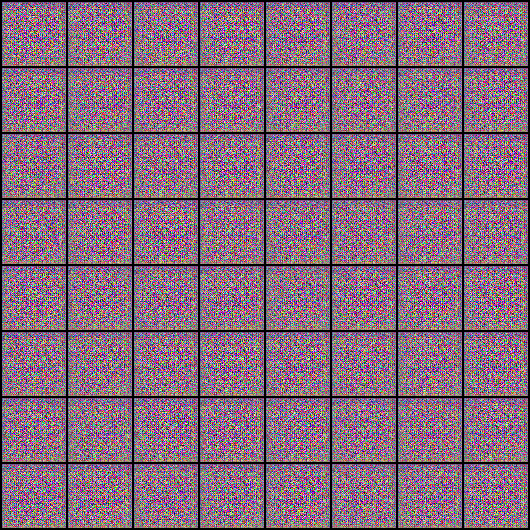

In [36]:
from IPython.display import Image
Image('./generated/generated_image_0300.png')

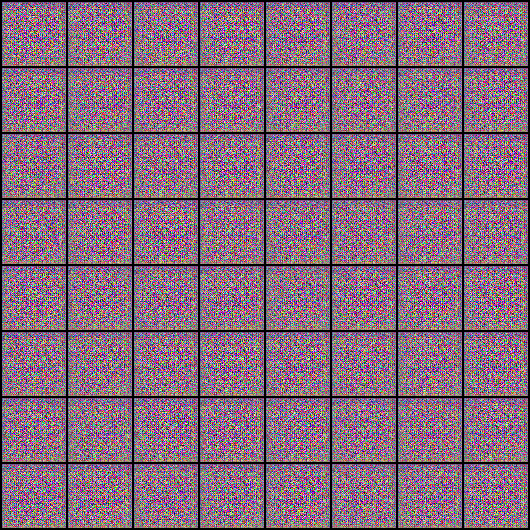

In [37]:
Image('./generated/generated_image_0200.png')